In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import yaml
import statsmodels.api as sm
import seaborn as sns
from scipy.interpolate import interp1d
from scipy.stats import lognorm
import pickle
import numpy as np
sys.path.append('/home/xfang2/repos/celldetection')
import sma
from scipy.integrate import solve_ivp
import pandas as pd

In [2]:
# format data to be compatible w data processed by fit_multiplechannels.py
class container():
    def __init__(self,fileName,
                    index=None,# none- single channel image; int otherwise
                    raw = None # array of data; usually leave undefined 
                    ):
        self.fileName=fileName
        self.index = index
        self.raw = raw       
        

In [4]:
# dydt function
def dydt(t,y,params):
    cyto, ER1, ER2=y
    
    kSC=params['kSC']
    kRyr=params['kRyr']
    kcomp=params['kcomp']
    
    dcytodt = kRyr*ER2 - kSC*cyto
    dER1dt = kSC*cyto - kcomp*ER1
    dER2dt = kcomp*ER1 - kRyr*ER2
    
    return [dcytodt,dER1dt,dER2dt]

# normalization function
def minmax_scaling(data):
    data-=np.min(data)
    data/=np.max(data)
    
    return data

In [5]:
params=['kSC','kRyr','kcomp']
labels=['k$_{SERCA}$', 'k$_{Ryr}$', 'k$_{shuttle}$']
k_cols=['lightskyblue','deepskyblue','royalblue']

truthVals={
'kSC': [3.282861098239496, 2.285414583176121, 3.8596241810556586, 2.8124088623449723,2.143196686120475, 1.0723482647298106, 1.679732148309085, 1.800762611286055,3.7908909325080824, 2.7184168291764603, 3.4053324510734284, 1.9097836640458818], 
'kRyr': [0.017117645066539955, 0.023548651761230954, 0.023438353654869667, 0.017453905982330604,0.021621813646280765, 0.02115636776392014, 0.025284632768517543, 0.013812377787083038,0.004816891459821002, 0.0060589691875711504, 0.004602159771800009, 0.005337437653613972], 
'kcomp': [1.3040810567497516, 0.7169019119117946, 1.5990092884271527, 1.5579059658090963,0.4797353675370818, 0.4344030655861066, 0.5193421376470359, 0.5553438910956742,3.6285471437356334, 3.627562953376599, 3.518230375010903, 2.9267450550913954], 
}

In [11]:
# data to fit
exptFile='/home/xfang2/backup/faust_backup/automagikFitting/pymc3/cicr/expt/peaks_downsampled.csv'
simFile='/home/xfang2/backup/faust_backup/automagikFitting/pymc3/cicr/sim/simData/trans_multiClass.pkl'
simData=pickle.load( open(simFile,'rb'))
exptData=np.genfromtxt(exptFile, delimiter=',',skip_header=1)  
data={'sim':{'cyto':[],'ER':[]},'expt':{'cyto':[],'ER':[]}}
frameRate={'sim':0.05,'expt':3.0e-2} # sec/frame
nIter=50
nCells={'sim':len(simData['channel1'].processed),'expt':int(exptData.shape[1]/2)}

for key in data.keys():
    n=nCells[key]
    for cell in range(n):
        if key == 'sim':
            channel1=simData['channel1'].processed[cell]
            channel2=simData['channel2'].processed[cell]
        else:
            channel1=exptData[:,cell*2]
            channel2=exptData[:,cell*2+1]
            channel1=channel1[~np.isnan(channel1)]
            channel2=channel2[~np.isnan(channel2)]
        data[key]['cyto'].append(channel1)
        data[key]['ER'].append(channel2)

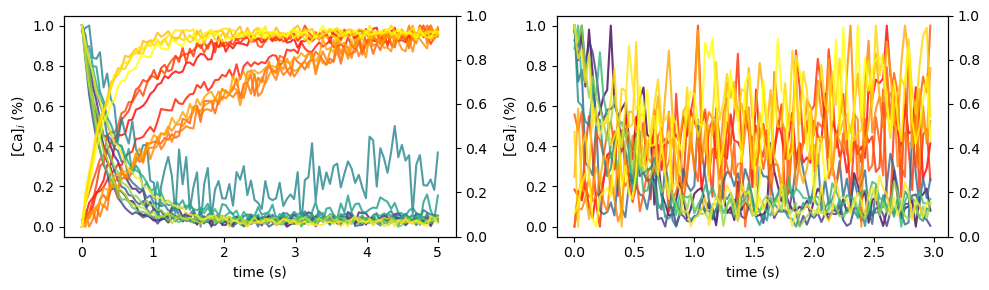

In [7]:
cmap1=matplotlib.colormaps['viridis']
cmap2=matplotlib.colormaps['autumn']

rcParams['figure.figsize']=10,3
fig=plt.figure()
for i,key in enumerate(data.keys()):
    n=nCells[key]
    gradient=np.linspace(0,1,n)
    ax=fig.add_subplot(1,2,i+1)
    axr=ax.twinx()
    ax.set_xlabel('time (s)')
    ax.set_ylabel('[Ca]$_i$ (%)')
    for cell in range(n):
        channel1=data[key]['cyto'][cell]
        channel2=data[key]['ER'][cell]
        stepSize=len(channel1)
        ts=np.linspace(0,stepSize*frameRate[key],stepSize)
        channel1-=np.min(channel1)
        channel1/=np.max(channel1)
        channel2-=np.min(channel2)
        channel2/=np.max(channel2)
        ax.plot(ts,channel1,color=cmap1(gradient[cell]),alpha=0.8)
        ax.plot(ts,channel2,color=cmap2(gradient[cell]),alpha=0.8)
plt.tight_layout()

In [8]:
rcParams['figure.dpi']=300

In [26]:
# load inference data
path='/home/xfang2/backup/faust_backup/automagikFitting/pymc3/freq_fit/cicr'
model=1
nParams=len(params)
infData={}
infData['sim']=[]
infData['expt']=[]


for key in data.keys():
    n=nCells[key]
    
    for cell in range(n):
        ps={}
        
        for p in range(nParams):
            results=np.genfromtxt(path+'/model{}/fit_results_{}_{}.csv'.format(model,key,p),delimiter=',')
            param_name=params[p]
            ps[param_name]=results[:,cell]
            
        infData[key].append(ps)


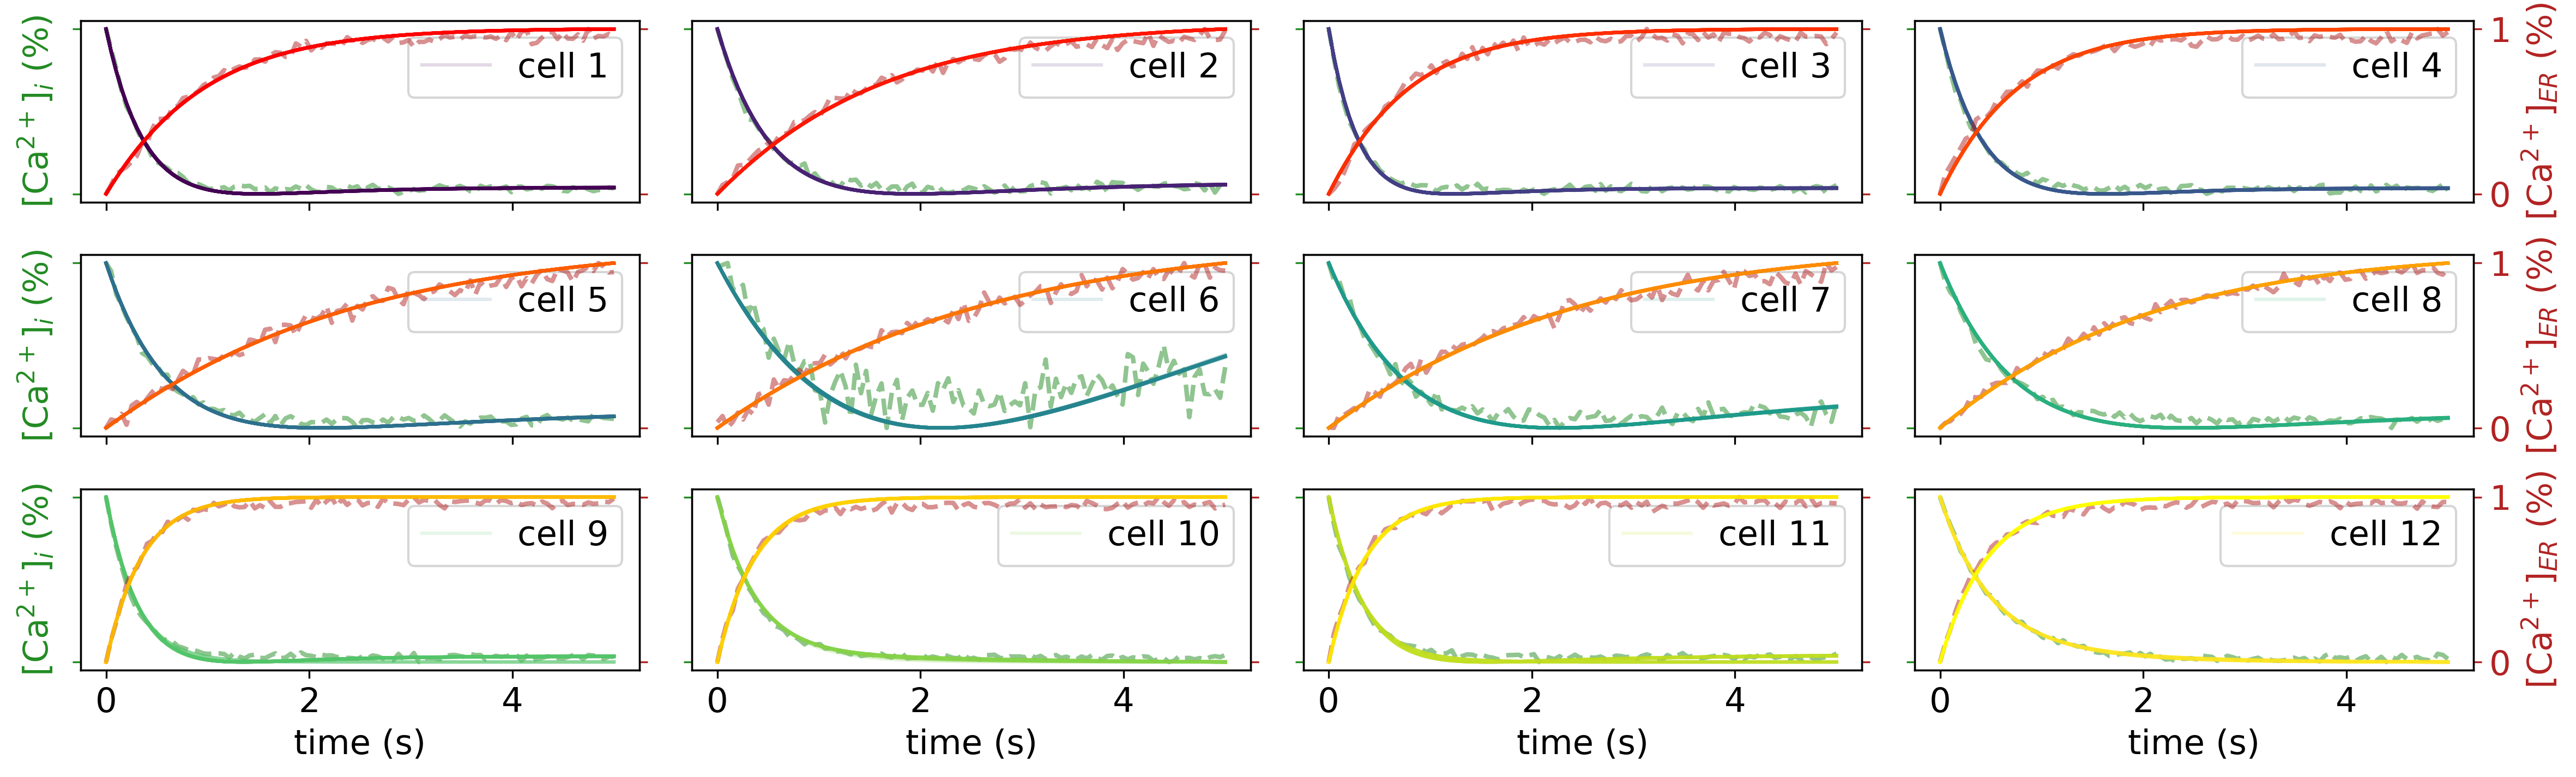

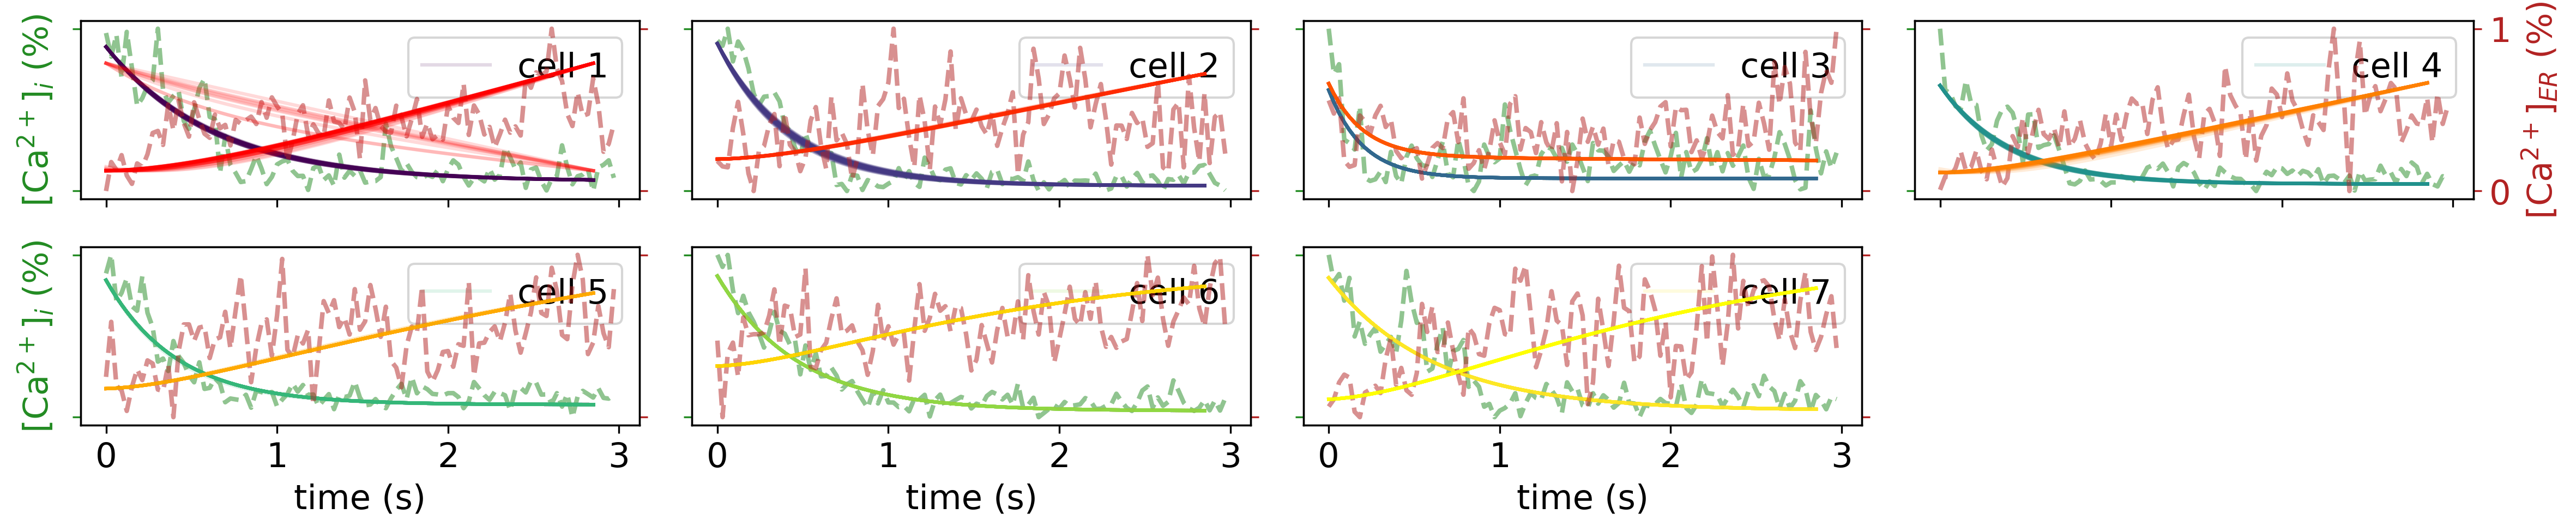

In [27]:
# fit
rcParams['font.size']=15
mses={'sim':{'cyto':[],'ER':[]},
      'expt':{'cyto':[],'ER':[]}}

for key in data.keys():
    if key=='expt':
        rcParams['figure.figsize']=16,3.5
        nrows,ncols=2,4
    else:
        rcParams['figure.figsize']=16,5
        nrows,ncols=3,4
    
    n=nCells[key]
    df=infData[key]
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex='col', sharey='row')
    cell=0
    gradient=np.linspace(0,1,n)
    
    for row in range(nrows):
        for col in range(ncols):
            ax = axes[row, col]    
            axr=ax.twinx()
            ax.tick_params(axis='y', colors='forestgreen')
            axr.tick_params(axis='y', colors='firebrick')
            
            mse1=[]
            mse2=[]

            if col == 0:  # Leftmost column
                ax.set_ylabel('[Ca$^{2+}$]$_i$ (%)',color='forestgreen')    
            else:
                ax.set_yticklabels([])
            if col == ncols-1:
                axr.set_ylabel('[Ca$^{2+}$]$_{ER}$ (%)',color='firebrick')
            else:
                axr.set_yticklabels([])
            if row == nrows - 1:  # Bottom row
                ax.set_xlabel('time (s)')
                
            try:
                channel1=data[key]['cyto'][cell]
                channel2=data[key]['ER'][cell]
            except:
                ax.set_visible(False) 
                axr.set_visible(False) 
                continue

            channel1=minmax_scaling(channel1)
            channel2=minmax_scaling(channel2)
            
            # raw data
            stepSize=len(channel1)
            ts=np.linspace(0,stepSize*frameRate[key],stepSize) 
            ax.plot(ts,channel1,lw=2,color='forestgreen',alpha=0.5,linestyle='--')  
            axr.plot(ts,channel2,lw=2,color='firebrick',alpha=0.5,linestyle='--')  

            # run sma on experimental data
            if key == 'expt':
                # sma
                window1=window2=5
                channel1=sma.sma(window1,channel1)
                channel2=sma.sma(window2,channel2)
                stepSize1=len(channel1)
                ts=np.linspace(0,stepSize1*frameRate[key],stepSize1)
                stepSize2=len(channel2)
                ts2=np.linspace(0,stepSize2*frameRate[key],stepSize2)
                # to ensure the two channels have the same time steps, we interpolate channel2 over the time steps of channel1
                interp_func=interp1d(ts2,channel2,fill_value='extrapolate')
                channel2=interp_func(ts)              

            y01=channel1[0]
            y02=channel2[0]

            channel1Min,channel1Max,channel2Min,channel2Max=np.min(channel1),np.max(channel1),np.min(channel2),np.max(channel2)

            varDict={}
            
            for k in range(nIter):
                for i,param in enumerate(params):
                    varDict[param]=infData[key][cell][param][k]

                if key == 'sim':
                    y0s=[y01, 10., y02]
                else:
                    y0s=[y01, 0.1, y02]
                ys = solve_ivp(dydt,[0,ts[-1]],y0s,args=(varDict,),t_eval=ts,method='LSODA').y
                sim1,sim2=ys[0],ys[2] 
                
                # normalization
                sim1=minmax_scaling(sim1)
                sim2=minmax_scaling(sim2)
                sim1=sim1*(channel1Max-channel1Min)+channel1Min
                sim2=sim2*(channel2Max-channel2Min)+channel2Min
                
                ax.plot(ts,sim1,alpha=0.15,color=cmap1(gradient[cell]),label='cell {}'.format(cell+1))
                axr.plot(ts,sim2,alpha=0.15,color=cmap2(gradient[cell]),label='cell {}'.format(cell+1))
                
                if k==0:
                    ax.legend(loc=0)
                    
                # MSE
                m1=np.mean((sim1-channel1)**2)
                mse1.append(m1)
                m2=np.mean((sim2-channel2)**2)
                mse2.append(m2)
            
            cell+=1
            
            mses[key]['cyto'].append(mse1)
            mses[key]['ER'].append(mse2)
            
    plt.tight_layout()
    plt.gcf().savefig('model{}_de_fit_{}.png'.format(model,key))
    
    

/tmp/ipykernel_31538/2554471477.py:33: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(v,color=cmap1(gradient[cell]),fill=True).set(ylabel=None)
/tmp/ipykernel_31538/2554471477.py:33: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(v,color=cmap1(gradient[cell]),fill=True).set(ylabel=None)


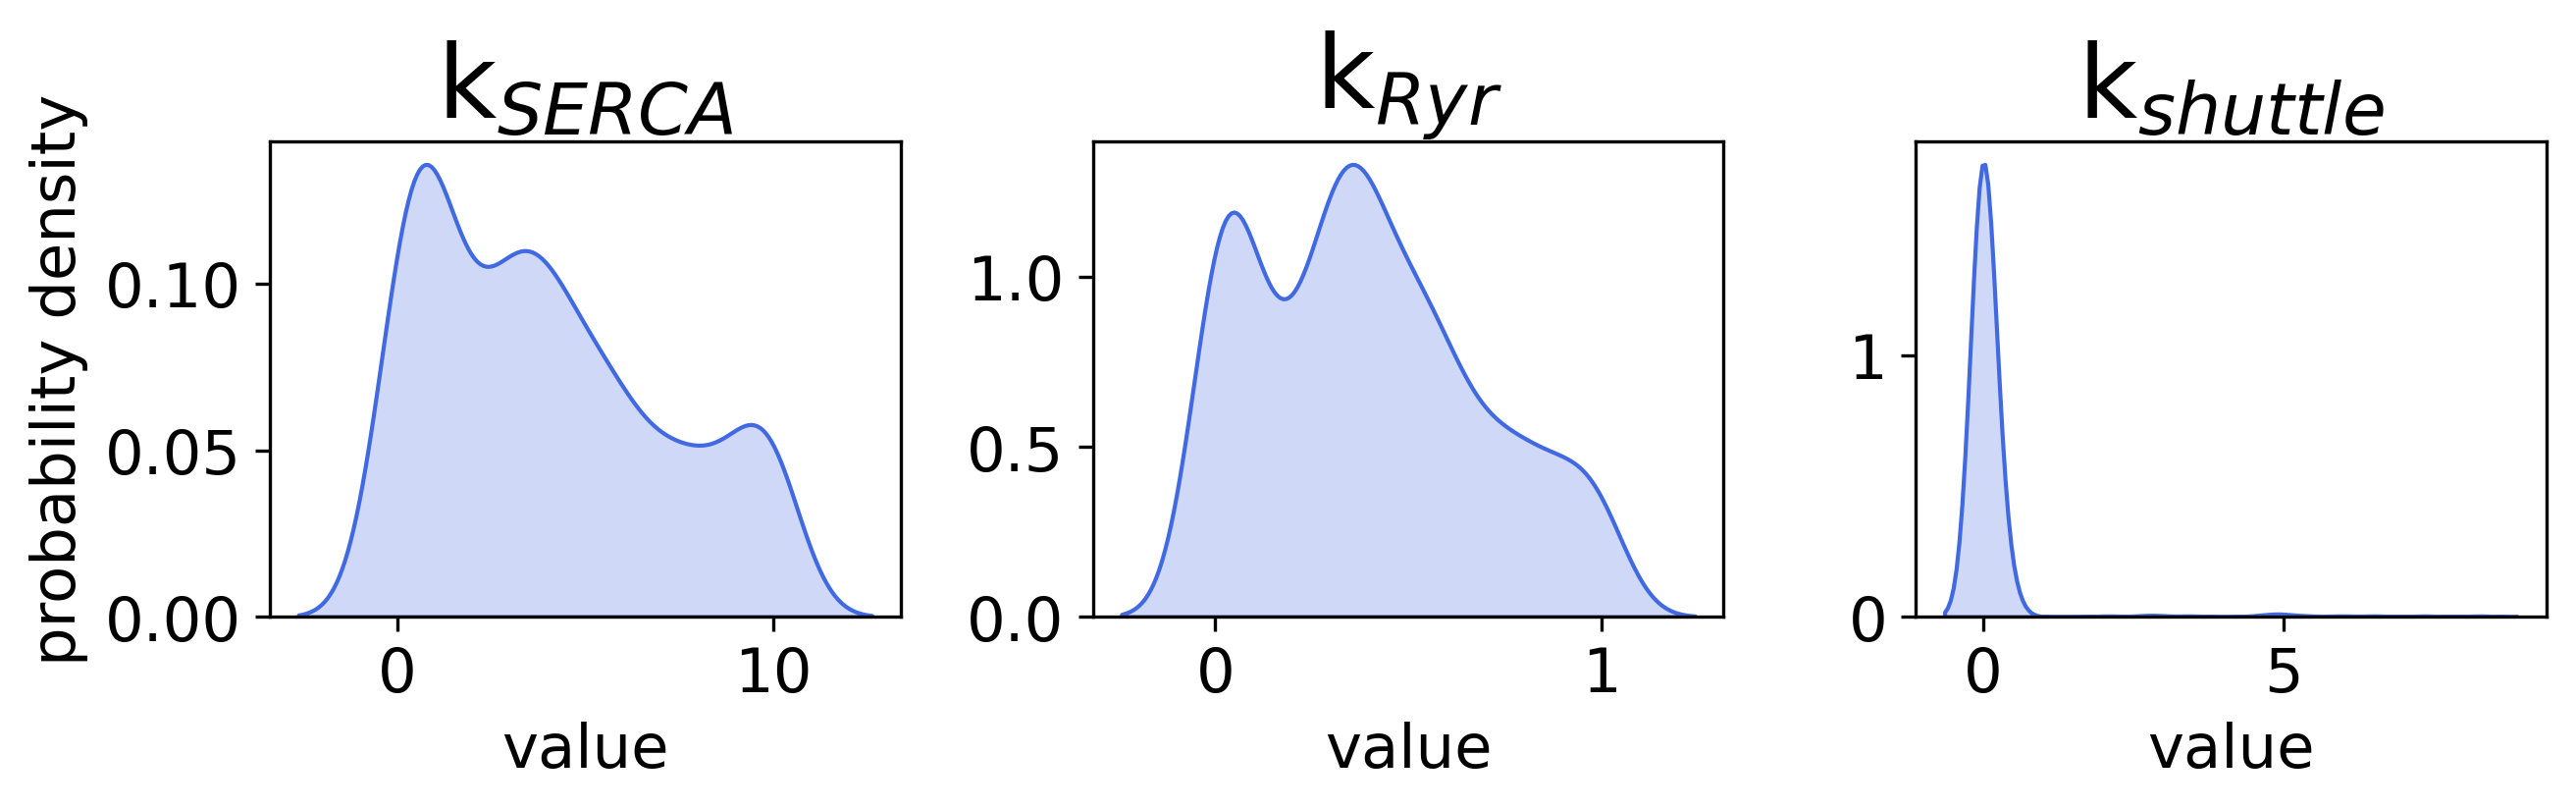

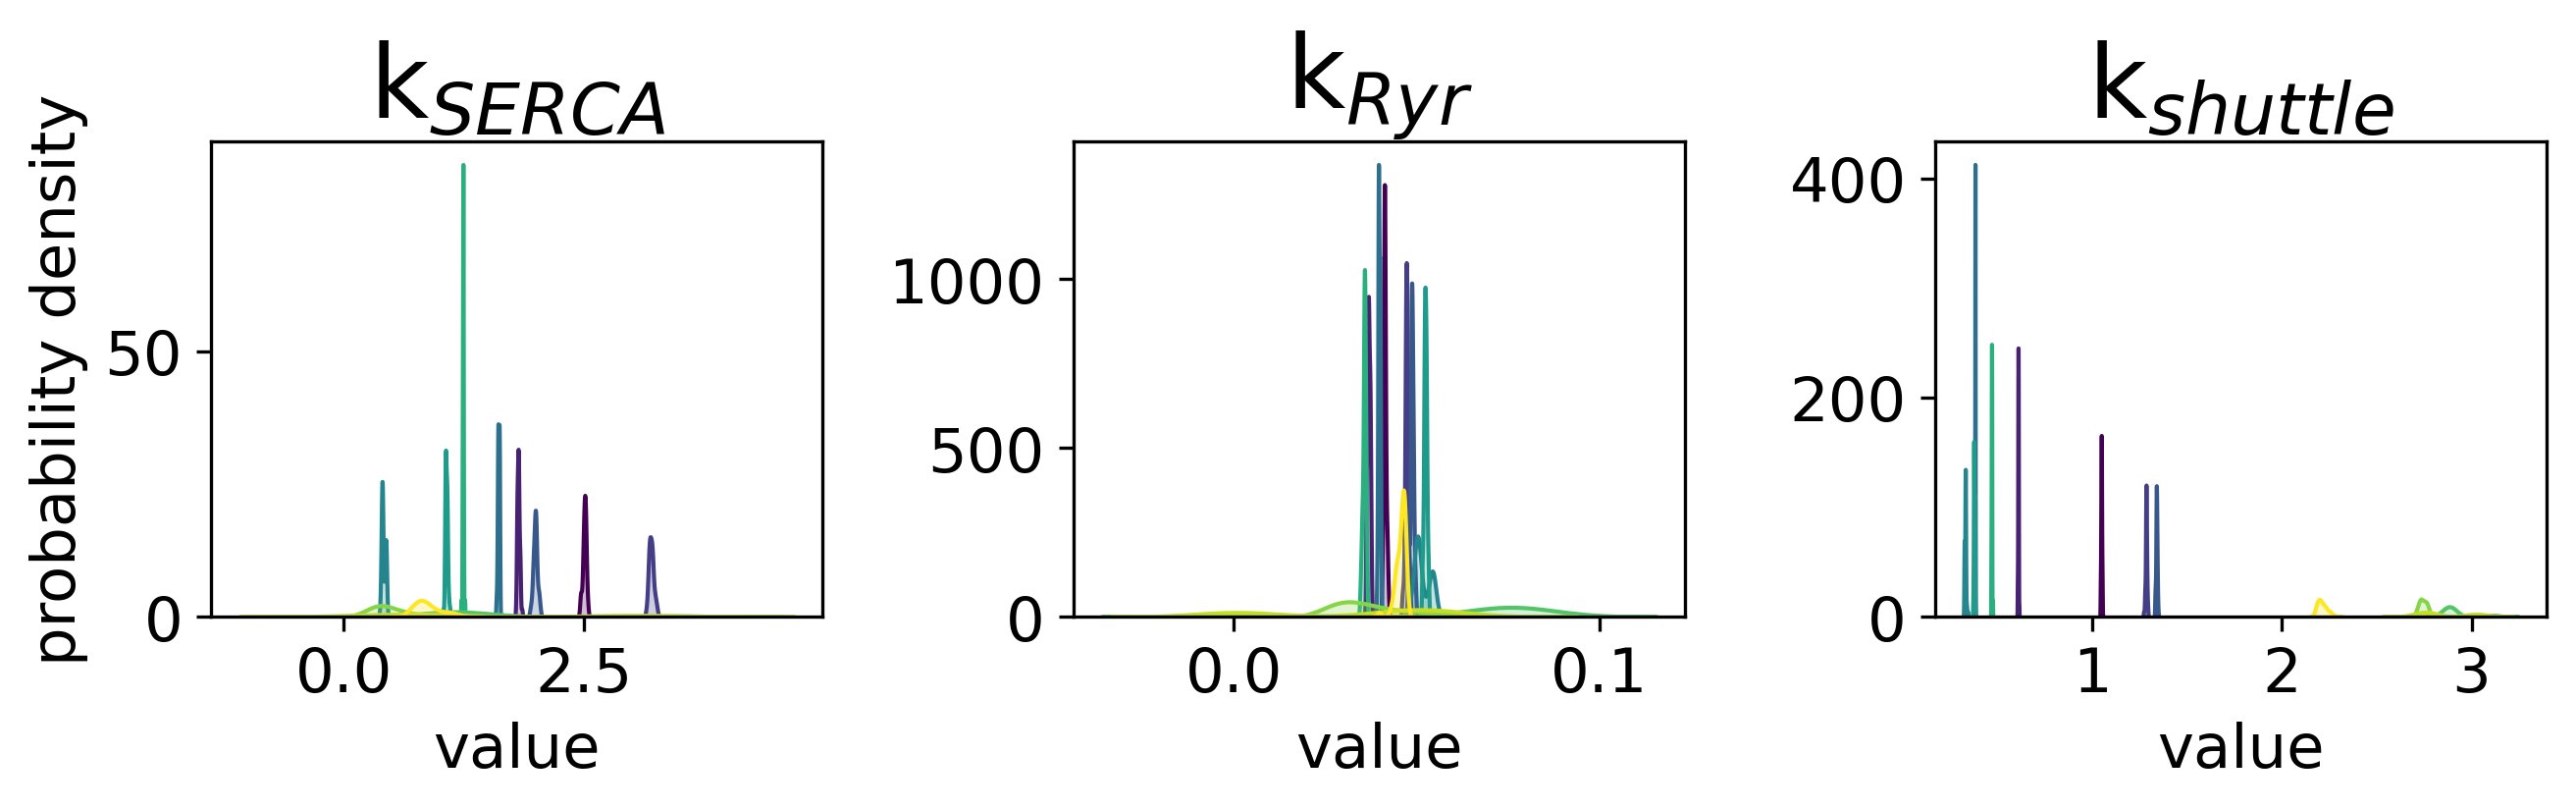

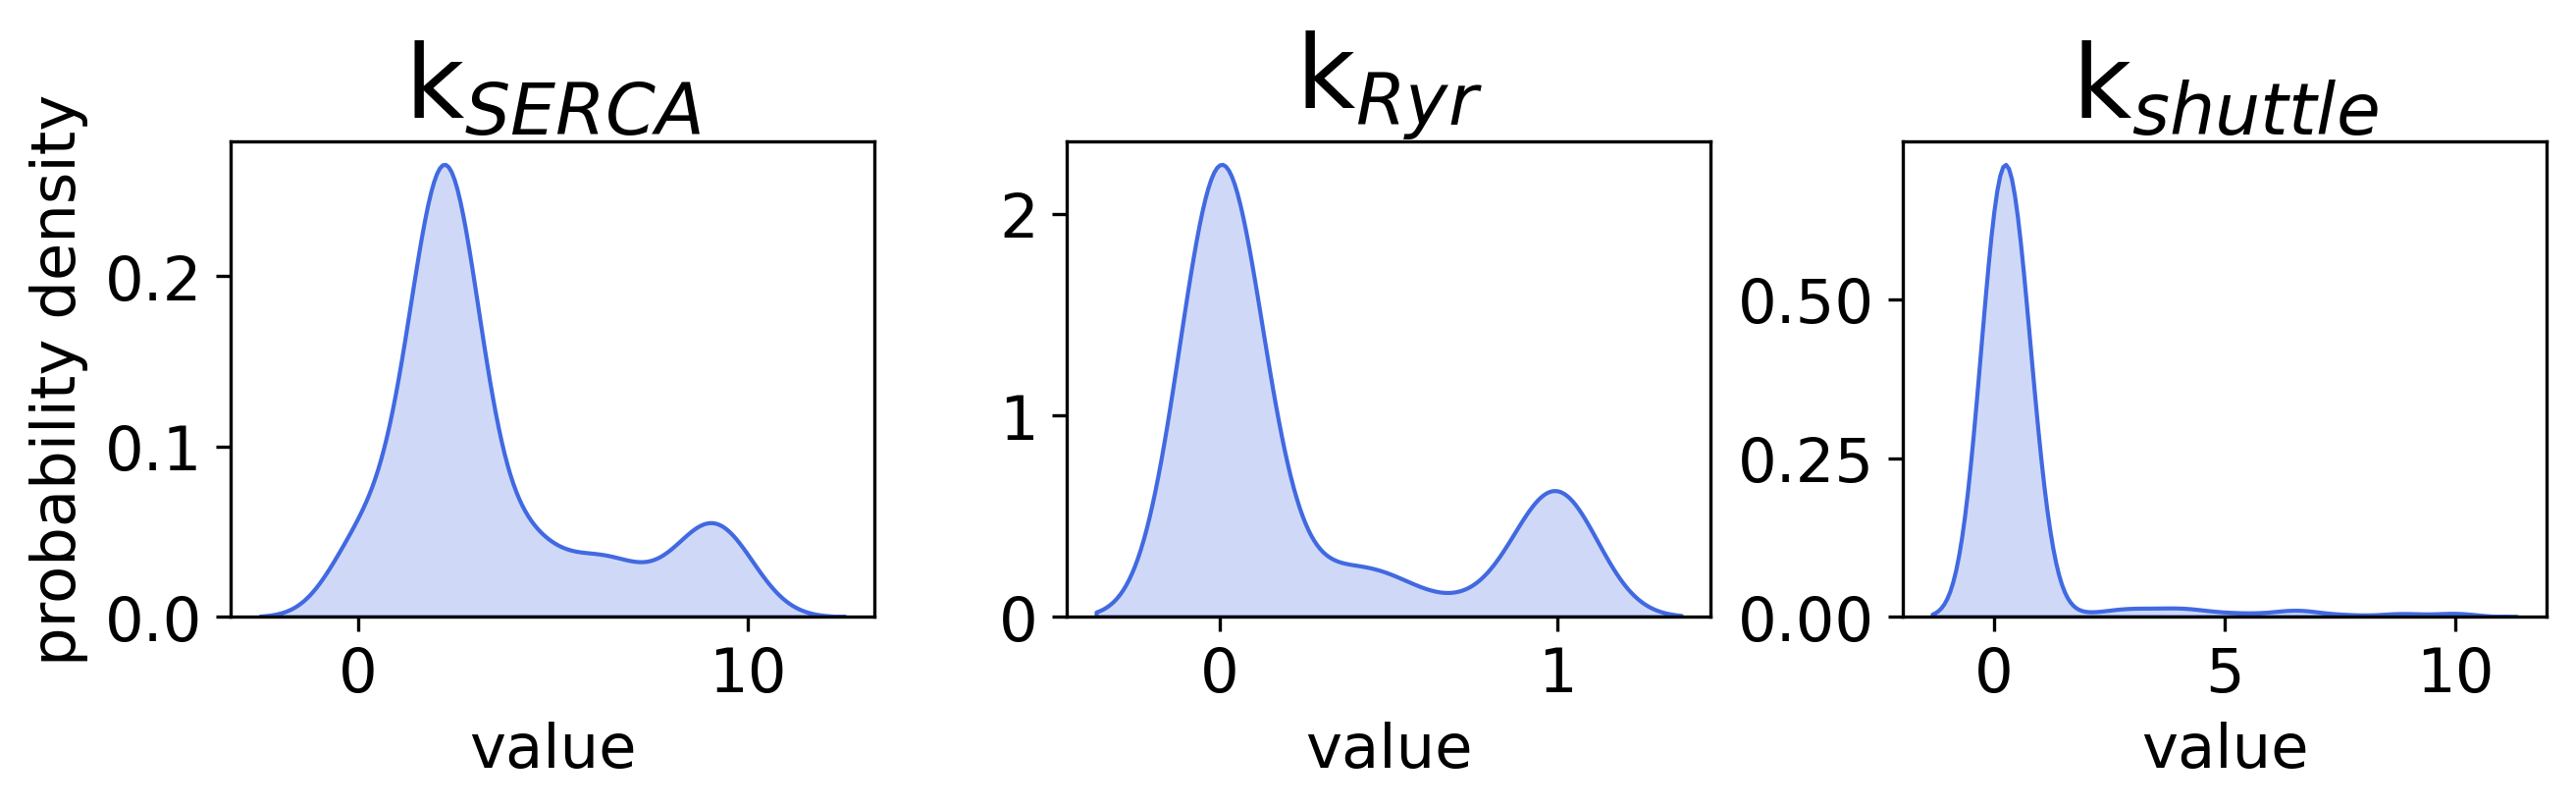

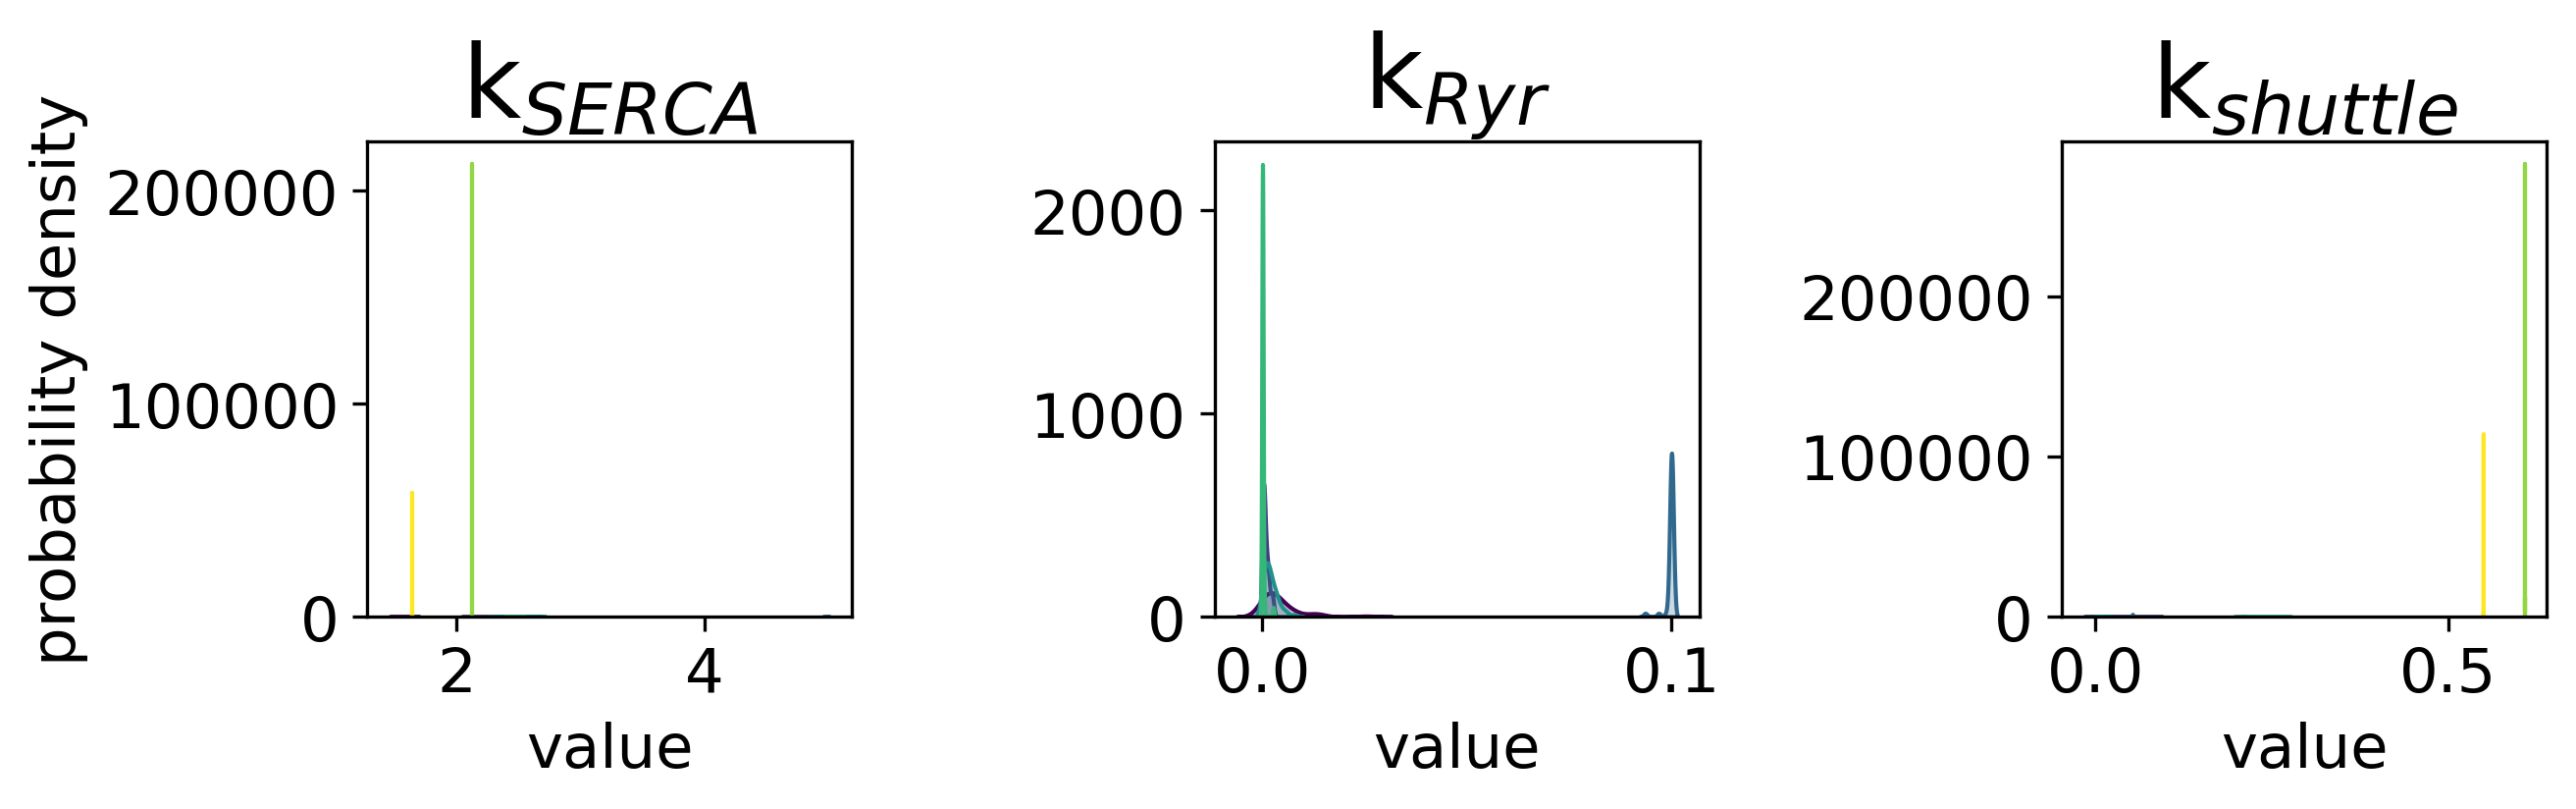

In [28]:
rcParams['font.size']=15
rcParams['figure.figsize']=9,3

for key in data.keys():
    fig=plt.figure()
    for i,p in enumerate(params):
        ax=fig.add_subplot(1,3,i+1)
        ax.set_title(labels[i],fontsize=25)
        ax.set_xlabel('value')

        vals=np.genfromtxt(path+'/model{}/v2/fit_results_{}_{}.csv'.format(model,key,i),delimiter=',').ravel()

        sns.kdeplot(vals,color='royalblue',fill=True).set(ylabel=None)

        if i==0:
            ax.set_ylabel('probability density')

    plt.tight_layout()
    plt.gcf().savefig('model{}_de_dist_{}.png'.format(model,key))

    
    fig=plt.figure()
    n=nCells[key]
    gradient=np.linspace(0,1,n)

    for i,param in enumerate(params):
        ax=fig.add_subplot(1,3,i+1)
        ax.set_title(labels[i],fontsize=25)
        ax.set_xlabel('value')

        for cell in range(n):
            v=infData[key][cell][param]
            sns.kdeplot(v,color=cmap1(gradient[cell]),fill=True).set(ylabel=None)
            
        if i==0:
            ax.set_ylabel('probability density')

    plt.tight_layout()
    plt.gcf().savefig('model{}_de_dist_cell_{}.png'.format(model,key))

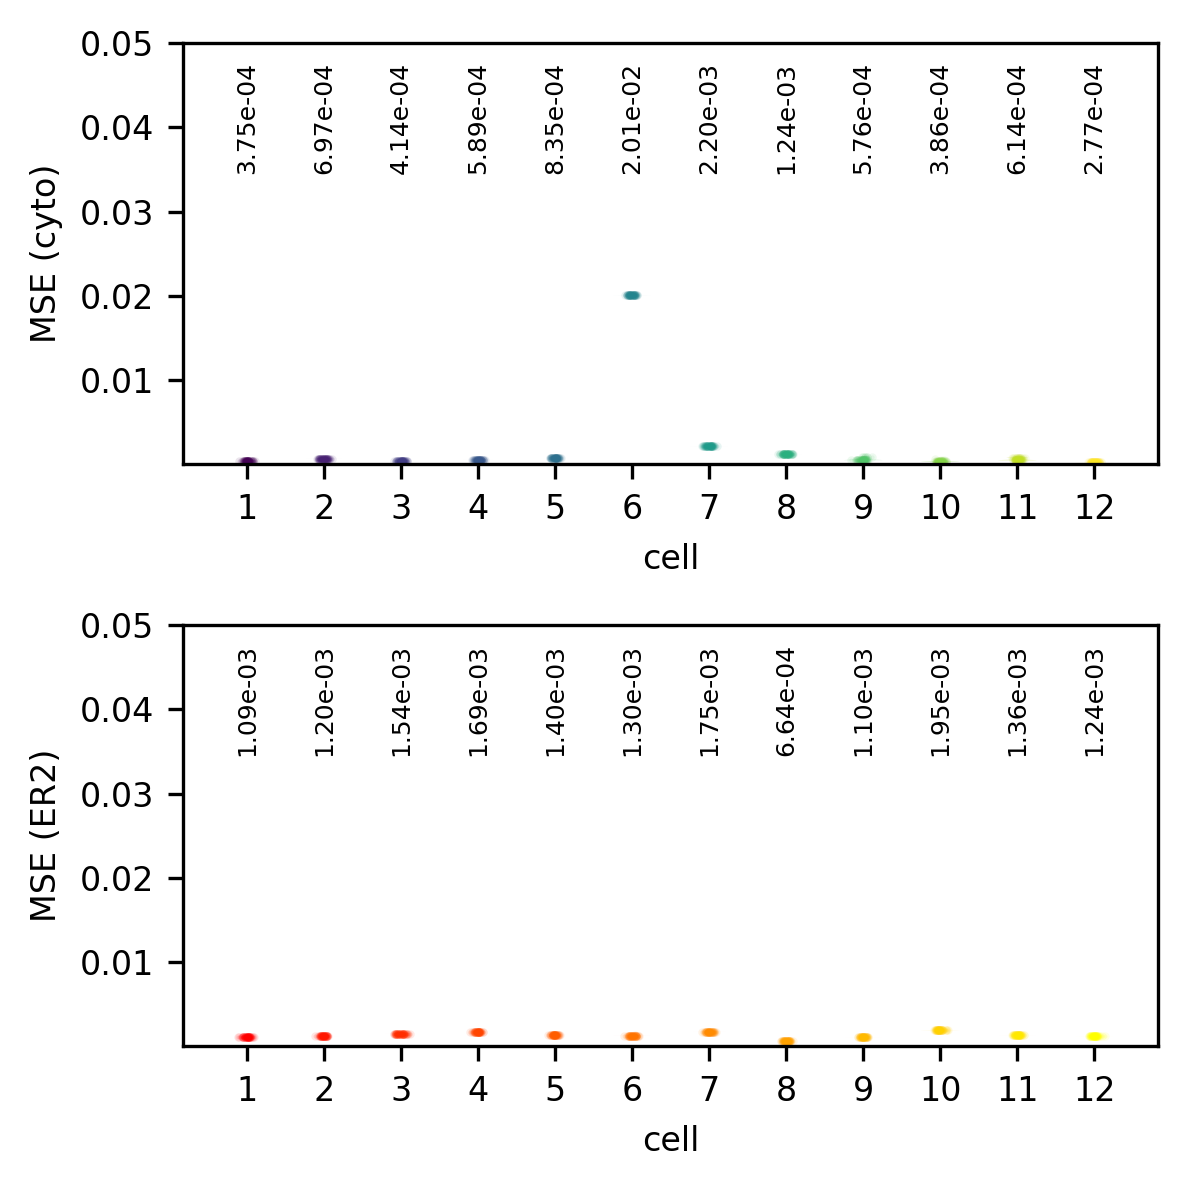

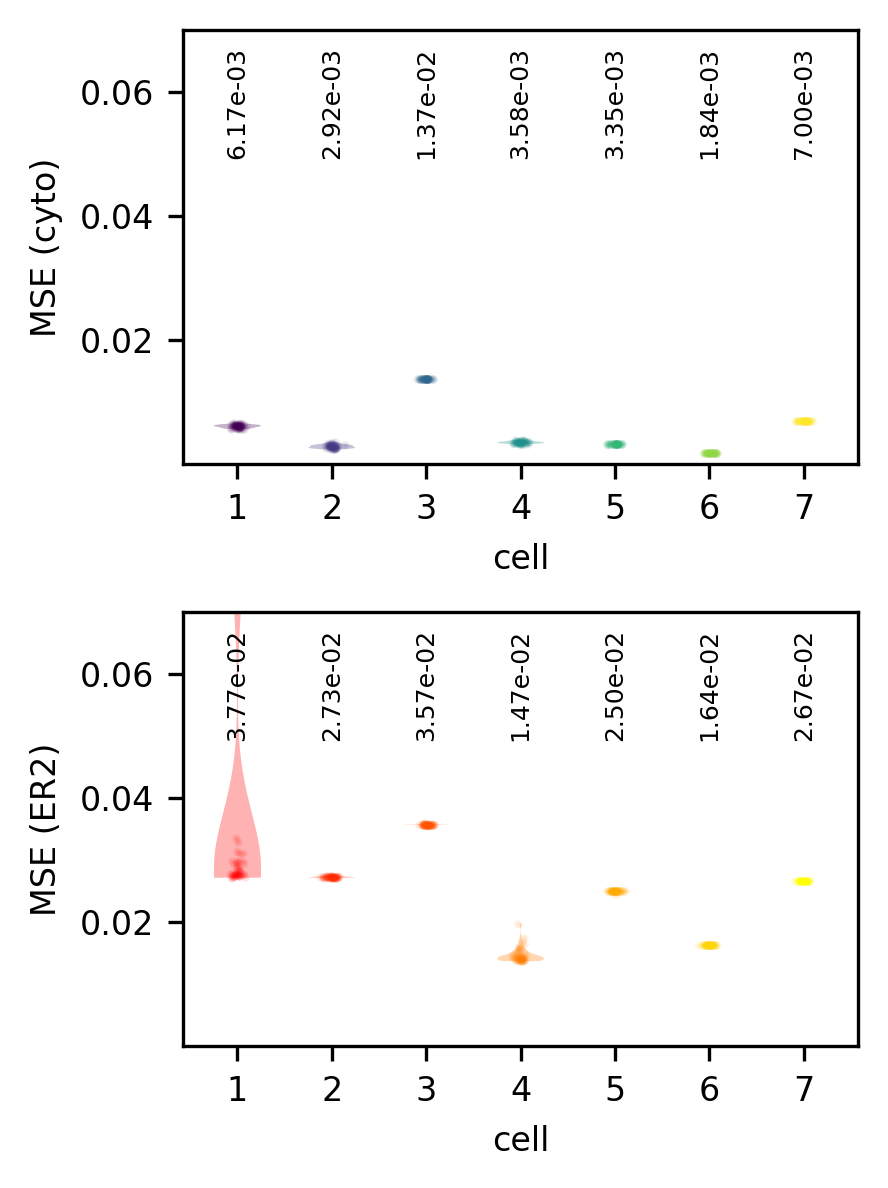

In [29]:
rcParams['font.size']=8
ylabels=['cyto','ER2']

for i,key1 in enumerate(mses.keys()):
    if key1=='sim':
        rcParams['figure.figsize']=4,4
    else:
        rcParams['figure.figsize']=3,4
        
    fig=plt.figure()
    n=nCells[key1]
    gradient=np.linspace(0,1,n)
    
    for j,key2 in enumerate(mses[key1].keys()):
        ax=fig.add_subplot(2,1,j+1)
        ax.set_xlabel('cell')
        ax.set_xticks(np.arange(n+1))
        ax.set_ylabel('MSE ({})'.format(ylabels[j]))
        if key1 == 'sim':
            ax.set_ylim([0.00005, 0.05])
            yloc=0.035
        else:
            ax.set_ylim([0.00005, 0.07])
            yloc=0.05
            
        vals=mses[key1][key2]
        parts=ax.violinplot(vals,showextrema=False)
        for idx,pc in enumerate(parts['bodies']):
            if key2=='cyto': 
                pc.set_facecolor(cmap1(gradient[idx]))
            else:
                pc.set_facecolor(cmap2(gradient[idx]))
            pc.set_alpha(0.3)
        
        for cell in range(n):
            ys=vals[cell]
            ys=np.array(ys)
            ys = ys[~np.isnan(ys)]
            xs=np.random.normal(cell+1, 0.04, len(ys))
            if j == 0:
                ax.scatter(xs,ys,s=1,color=cmap1(gradient[cell]),alpha=0.1)
            else:
                ax.scatter(xs,ys,s=1,color=cmap2(gradient[cell]),alpha=0.1)
            
            avg=np.mean(ys)
            ax.annotate(f"{avg:.2e}", xy=(cell+1, yloc),fontsize=6,
                horizontalalignment="center",rotation=90,
                       )

    plt.tight_layout()
    plt.gcf().savefig('model{}_de_mse_{}.png'.format(model,key))